# Programming a deep feed-forward network

This notebook is based on a fabulous [Kaggle tutorial by DATAI](https://www.kaggle.com/kanncaa1/deep-learning-tutorial-for-beginners) and uses the "sign language digits data set", also found through the link.

We start by loading the relevant packages:

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 1. The dataset (this part is identical to the logistic regression exercise)

The dataset contains 64x64 images of the signs used to represent the ten digits, 0-9. Indexes 204 to 408 of the dataset show the sign for zero and indexes 822 to 1027 show the sign for one.

In [56]:
X = np.load('digits_X.npy')
y = np.load('digits_y.npy')

Each value of `X` is a matrix with pixel values, while each value of `y` is a vector representing the value of the digit (one-hot encoded):

In [72]:
X.shape

(411, 64, 64)

In [51]:
X[204].shape

(433, 64, 64)

In [41]:
y[204]

array([0.])

We can, of course, display the images:

(-0.5, 63.5, 63.5, -0.5)

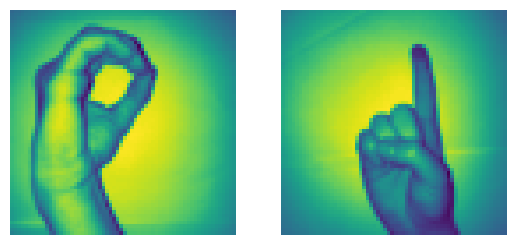

In [57]:
img_size = 64
plt.subplot(1, 2, 1)
plt.imshow(X[204].reshape(img_size, img_size))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(X[822].reshape(img_size, img_size))
plt.axis('off')

We only need the zeros and ones for our purposes. Hence, start by gathering only the relevant X-variables:

In [73]:
X = np.concatenate((X[204:409], X[822:1028] ), axis=0)
X.shape

(205, 64, 64)

In [74]:
X[822:1028]


array([], shape=(0, 64, 64), dtype=float32)

For the ys, we also only want the relevant ones. Moreover, we want to make sure that instead of a vector, we simply have 0 if the digit is zero and 1 if it is one:

In [59]:
z = np.zeros(409-204)
o = np.ones(1028-822)
y = np.concatenate((z, o), axis=0).reshape(X.shape[0],1)

In [63]:
o.shape

(206,)

In [64]:
z.shape

(205,)

With the `reshape`, we make sure that `y` is a vector with two dimensions:

In [9]:
print(X.shape)
print(y.shape)

(411, 64, 64)
(411, 1)


Next, we split the data into training and testing with 15% in the test set (you know the drill):

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=172)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(349, 64, 64)
(349, 1)
(62, 64, 64)
(62, 1)


Finally, we need to "flatten" the Xs. Currently, our input is three-dimensional (each observation is a matrix). However, when we run regressions (or train models more generally), we usually have two-dimensional inputs, as it makes things a lot easier to work with. There are exceptions to this of course, specifically when using convolutional neural networks, but let's not get ahead of ourselves.

What we will do is to convert each matrix (each observation's X-value) to a vector, simply by stacking all the columns of the matrix. If $X^{(i)} \in \mathcal{R}^{n \times m}$, then the fitting vector $\hat{X}^{(i)} \in \mathcal{R}^{n m}$. So we reshape accordingly:

In [65]:
X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test_flat = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])
print(X_train_flat.shape)
print(X_test_flat.shape)

(349, 4096)
(62, 4096)


We have 4096 pixels per observation, neatly stacked in a vector. All observations together (349 for train, 62 for test), gives us a (two-dimensional) matrix.

## 2. A neural network with an (arbitrarily large) hidden layer of neurons

This time, we are creating a model that uses multiple neurons instead of just one. In particular, we will use one hidden layer with `hidden_layer_size` neurons (and the ReLU activation function), and an output layer with a single neuron performing the final binary classification (what activation function do we use here?)

The principle approach is the same as before:

0. Choose hyperparameters
1. Initialize the model parameters $\theta$ (random weights!)
2. Until we cannot improve the cost function anymore (or we reach a certain numer of iterations):
- Given your current model parameters, compute the cost function $J(\theta)$ (forward propagation)
- From the cost function, go backward to compute all the relevant derivatives (back-propagation)
- Update the parameters: $\theta := \theta - \alpha \nabla_{\theta} J(\theta)$

### Initialization

Keep in mind that each neuron in the hidden layer has weights for all $m$ incoming edges (i.e. one for each `dimension`), as well as one bias term. The single neuron in the output layer has one weight for each of its incoming edges, as well as its own bias term.

We will usually use dictionaries to store parameters when we have many. The function below is partially completed for you - can you finish it?

In [12]:
def initialize_parameters(seed=392, dimension=4096, hidden_layer_size=3):
    np.random.seed(seed)
    parameters = {
        "weights1": np.random.rand(dimension, hidden_layer_size)
        * 0.01,  # Use np.random.rand(dim1,dim2)*0.01, inputing the correct dimensions
        "bias1": np.zeros(
            (1, hidden_layer_size)
        ),  # Use np.zeros(shape), inputing the correct shape
        "weights2": np.random.randn(hidden_layer_size, 1)
        * 0.01,  # Use np.random.randn(dim1,dim2)*0.01, inputing the correct dimensions
        "bias2": np.zeros((1, 1)),
    }  # Use np.zeros(shape), inputing the correct shape
    return parameters

A quick try:

In [70]:
parameters = initialize_parameters(seed=123,dimension=4096,hidden_layer_size=3)
print(parameters["weights1"].shape)
print(parameters["bias1"].shape)
print(parameters["weights2"].shape)
print(parameters["bias2"].shape)

(4096, 3)
(1, 3)
(3, 1)
(1, 1)


### Forward propagation

The forward propagation step is quite similar to what we saw in the logistic regression. Of course, our model for $\hat{y}$ is now a whole lot more complex. But that doesn't matter: the neural network is essentially a computation graph, so we just go layer by layer, and computations are quite easy at each layer. We will make use of two helper functions to compute the ReLU activation (at the hidden layer) and the logistic sigmoid activation (at the output layer).

In [16]:
def relu(z):
    return np.maximum(0,z)     # for proper vectorization, you might want to look up `np.maximum`

In [17]:
def sigma(z):
    return 1/(1 + np.exp(-z))  # you have seen this before in logistic regression

Remember that we want to make fast computations. Hence, our functions need to be able to take a whole matrix of values and compute the activation for each element (they need to be "vectorized"). Try it out for both activation functions below:

In [18]:
Z = np.array([[1,-2,3],
              [0,6,-2],
              [3,-1,0]])
print(relu(Z))
print(sigma(Z))

[[1 0 3]
 [0 6 0]
 [3 0 0]]
[[0.73105858 0.11920292 0.95257413]
 [0.5        0.99752738 0.11920292]
 [0.95257413 0.26894142 0.5       ]]


Next comes the actual forward propagation step. Remember that we need to compute:
1. For each neuron at the first layer:
- $Z^{[1]}$ = the weighted sum of the inputs X, to which we add the bias
- $A^{[1]}$ = the actual activation: the neuron's activation function applied to $Z^{[1]}$
2. For the neuron at the second layer:
- $Z^{[2]}$ = the weighted sum of the inputs $A^{[1]}$, to which we add the bias
- $A^{[2]}$ = the actual activation: the neuron's activation function applied to $Z^{[2]}$
3. The cost function, given $\hat{y} = A^{[2]}$: We will stick with what we saw before in binary classification, so $J=\frac{1}{n}\sum_{i=1}^n L^{(i)}$ with $L^{(i)} = -y^{(i)} \log \hat y^{(i)} - (1-y^{(i)}) (1-\log \hat y^{(i)})$

Aside from the cost, the forward propagation should return the computed Z's and A's in what we call a "cache". This is important for back-propagation later down the line.

We start with a naive implementation, where we compute the activations for each neuron separately. Do you see what happens in the function below? Can you complete the missing pieces?

A few hints:
- you might benefit from adding print statements and trying out the function using `forward_propagation_naive(X_train_flat,y_train,parameters,2)`
- The input matrix $X$ has dimensions $(n,m)$, where $n$ is the number of observations and $m$ the number of features
- The weight matrix $W^{[1]}$ has dimensions $(m,\text{hidden_layer_size})$
- The bias vector $b^{[1]}$ has dimensions $(1,\text{hidden_layer_size})$
- The weight matrix $W^{[2]}$ has dimensions $(\text{hidden_layer_size},1)$
- The bias vector $b^{[2]}$ has dimensions $(1,1)$

In [19]:
def forward_propagation_naive(X,y,parameters,hidden_layer_size):
    # Layer 1 (hidden layer)
    Z1 = np.zeros((X.shape[0],hidden_layer_size))
    A1 = np.zeros((X.shape[0],hidden_layer_size))
    for neuron in range(hidden_layer_size):
        w = parameters['weights1'][:,neuron] # find the right weight (recall that we stacked our weights with shape (in,out))
        b = parameters['bias1'][0,neuron]    # find the right bias term (recall that we stacked our biases with shape (1,out))
        z = np.dot(X,w) + b                  # compute z, using np.dot. Think of the correct dimensions!
        Z1[:,neuron] = z
        A1[:,neuron] = relu(z)
    
    # Layer 2 (output layer)
    Z2 = np.dot(A1,parameters['weights2']) + parameters['bias2'] # at the second layer, there is only one node. Use np.dot again, and watch out for the correct dimensions
    A2 = sigma(Z2)
    
    # Compute the cost
    yHat = A2
    cost = np.sum(-y*np.log(yHat) - (1-y)*np.log(1-yHat))/X.shape[0]
    
    # Compute the cache
    cache = {'Z1': Z1,
             'A1': A1,
             'Z2': Z2,
             'A2': A2}
    
    return cost, cache

Try it out. If there are no mistake, the code below should print out 0.7387257645994343

In [20]:
parameters = initialize_parameters(seed=123,dimension=4096,hidden_layer_size=3)
cost, _ = forward_propagation_naive(X_train_flat,y_train,parameters,3)
print(cost)

0.7387257645994343


We know that vectorization is faster, so we will vectorize not just on the observations, but also on the neurons within a layer (and then see that this is quite a bit faster). Can you complete the function?

A few additional hints here:
- Each neuron has its own total input z for each observations. Hence, $Z^{[1]}$ should have dimensions $(n,\text{hidden_layer_size})$
- The same logic holds for the neuron at the second layer. Hence, $Z^{[2]}$ should have dimensions $(n,1)$
- The activation matrix $A^{[l]}$ has the same dimensions as the total input matrix $Z^{[l]}$.

In [21]:
def forward_propagation(X,y,parameters):
    # Layer 1 (hidden layer)
    Z1 = np.dot(X,parameters['weights1']) + parameters['bias1']  # Use np.dot!
    A1 = relu(Z1)
    
    # Layer 2 (output layer)
    Z2 = np.dot(A1,parameters['weights2']) + parameters['bias2'] # Use np.dot!
    A2 = sigma(Z2)
    
    # Compute the cost - this is exactly as before!
    yHat = A2
    cost = np.sum(-y*np.log(yHat) - (1-y)*np.log(1-yHat))/X.shape[0]
    
    # Compute the cache
    cache = {'Z1': Z1,
             'A1': A1,
             'Z2': Z2,
             'A2': A2}
    
    return cost, cache

Try it out. If there are no mistake, the code below should print out
1. 0.7387257645994343
1. (349,3)
1. (349,3)
1. (349,1)
1. (349,1)

In [22]:
parameters = initialize_parameters(seed=123,dimension=4096,hidden_layer_size=3)
cost, cache = forward_propagation(X_train_flat,y_train,parameters)
print(cost)
print(cache['Z1'].shape)
print(cache['A1'].shape)
print(cache['Z2'].shape)
print(cache['A2'].shape)

0.7387257645994345
(349, 3)
(349, 3)
(349, 1)
(349, 1)


Let's now compare the difference in computation time. What we will do is to create 200 sets of initial parameters for a network of width 10 and apply forward propagation once:

In [23]:
iterations = 200
time_naive = 0
cost_naive = 0
time_vectorized = 0
cost_vectorized = 0

for it in range(iterations):
    parameters = initialize_parameters(seed=np.random.randint(1),dimension=4096,hidden_layer_size=10)
    # Running things with a for-loop:
    tic = time.process_time()
    cost,_ = forward_propagation_naive(X_train_flat,y_train,parameters,10)
    toc = time.process_time()
    time_naive += 1000*(toc-tic)
    cost_naive += cost
    # Running things "vectorized":
    tic = time.process_time()
    cost,_ = forward_propagation(X_train_flat,y_train,parameters)
    toc = time.process_time()
    time_vectorized += 1000*(toc-tic)
    cost_vectorized += cost

print ("Naive: Cost = " + str(cost_naive/iterations) + ", computation time = " + str(time_naive/iterations) + "ms")
print ("Vectorized: Cost = " + str(cost_vectorized/iterations) + ", computation time = " + str(time_vectorized/iterations) + "ms")

Naive: Cost = 0.7061321562751905, computation time = 154.50435500000012ms
Vectorized: Cost = 0.7061321562751905, computation time = 26.139105000000107ms


### Back-propagation

We move onto the second step of our update: finding the gradients. Make sure you use the chain rule. We will discuss in the tutorial how to derive the derivatives, but for the programming part, the relevant computations can be found below:
- `dZ2` $= \nabla_{Z^{[2]}} J = \frac{1}{n}(A^{[2]} - y)$  (this should give you a $(n,1)$ matrix - why?)
- `dW2` $=\nabla_{W^{[2]}} J  = (A^{[1]})^T  (\nabla_{Z^{[2]}} J)$ (this should give you a $(\text{hidden_layer_size},1)$ matrix - why?)
- `db2` $=\nabla_{b^{[2]}} J = \sum_{i=1}^n \frac{\partial J}{\partial z_1^{[2](i)}}$ (you are summing up over the entries of dZ2)
- `dZ1` $= \nabla_{Z^{[1]}} J = (\nabla_{Z^{[2]}} J) (W^{[2]})^T \circ E^{[1]}$. Here, $\circ$ is element-wise multiplication and $E^{[1]}$ is a matrix of the same dimensions as $Z^{[1]}$ that is 1 when the entry is positive and 0 otherwise (this should give you a $(n,\text{hidden_layer_size})$ matrix - why?)
- `dW1` $=\nabla_{W^{[1]}} J  = (X^T)(\nabla_{Z^{[1]}} J)$ (this should give you a $(m,\text{hidden_layer_size})$ matrix - why?)
- `db1` = $\left[ \nabla_{b^{[1]}_1} J, \nabla_{b^{[1]}_2} J,..., \nabla_{b^{[1]}_{\text{hidden_layer_size}}} J \right] = \left[\sum_{i=1}^n \frac{\partial J}{\partial z_1^{[1](i)}}, \sum_{i=1}^n \frac{\partial J}{\partial z_2^{[1](i)}}, ..., \sum_{i=1}^n \frac{\partial J}{\partial z_{\text{hidden_layer_size}}^{[1](i)}} \right]$ (you are summing up over **one** of the axes of dZ1 - be careful to choose the right one)

A final hint about computing $E^{[1]}$. See the code below:

In [24]:
Z = np.array([[1,-2,3],
              [0,6,-2],
              [3,-1,0]])
np.where(Z>0,1,0)

array([[1, 0, 1],
       [0, 1, 0],
       [1, 0, 0]])

We can now define the back-propagation step, which returns the gradients:

In [25]:
def back_propagation(X, y, parameters, cache):

    dZ2 = (cache["A2"] - y) / X.shape[0]
    dW2 = np.dot(cache["A1"].T, dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    dZ1 = np.dot(dZ2, parameters["weights2"].T) * np.where(cache["Z1"] > 0, 1, 0)
    dW1 = np.dot(X.T, dZ1)
    db1 = np.sum(
        dZ1, axis=0, keepdims=True
    )  # make sure to sum up over the right axis (see the np.sum documentation), and to set keepdims=True
    grads = {"weights1": dW1, "bias1": db1, "weights2": dW2, "bias2": db2}
    return grads

If everything is programmed correctly, the below code should print out

1. -0.000508086877680383
1. (4096, 3)
1. (1, 3)
1. (3, 1)
1. (1, 1)

In [71]:
parameters = initialize_parameters(seed=123,dimension=4096,hidden_layer_size=3)
cost, cache = forward_propagation(X_train_flat,y_train,parameters)
grads = back_propagation(X_train_flat,y_train,parameters,cache)
print(grads['weights1'][0,0])
print(grads['weights1'].shape)
print(grads['bias1'].shape)
print(grads['weights2'].shape)
print(grads['bias2'].shape)

-0.0005080868776803828
(4096, 3)
(1, 3)
(3, 1)
(1, 1)


### Putting it together: parameter updating and training

In each iteration of our learning procedure, we update the parameters, hopefully moving closer towards the optimum. How we update the parameters is determined by the gradient, as well as the learning rate (a hyper-parameter). Let's define one update step:
1. Compute the `forward_propagation` step (returning `cost` and `cache`)
1. Compute the `back_propagation` step (using `cache` from `forward_propagation`)
1. Update each entry in `parameters` as follows: $\theta := \theta - \alpha \nabla_{\theta} J$ (Because we made sure above that the shapes are "in the right way", we don't have to worry about individual parameters, but can update whole groups - also, we made sure that the parameters and their gradients are referenced in the same way in both dictionaries. Note that $\alpha$ is the learning rate)
1. Return the updated dictionary `parameters` and the `cost` from `forward_propagation`

In [27]:
def parameter_update(X,y,parameters,learning_rate):
    cost, cache = forward_propagation(X,y,parameters)
    grads = back_propagation(X,y,parameters,cache)
    for entry in parameters:
        parameters[entry] = parameters[entry] - learning_rate*grads[entry]
    return parameters, cost

We can now train our model, by running the parameter update multiple times. We will use 3 neurons at the hidden layer, a learning rate of 0.01 and run the algorithm for 2,500 iterations. Can you adjust the function below? Make sure to initialize the parameters with our custom-made function. Also, each time you run the parameter-update, store the resulting `cost` in a list `cost_list`. At the end, return the final `parameter` dictionary and the `cost_list`.

In [28]:
def model_training(X,y,hidden_layer_size=3,learning_rate=0.01,iterations=2500,verbose=True):
    parameters = initialize_parameters(seed=np.random.randint(1),dimension=X.shape[1],hidden_layer_size=hidden_layer_size) # Initialize the parameters
    cost_list = []
    for it in range(iterations):
        parameters,cost = parameter_update(X,y,parameters,learning_rate) # for each iteration, update the parameters using forward and back propagation
        cost_list.append(cost)  # Also, make sure to add the cost to the cost_list
        if verbose:
            print('Cost after iteration %i: %f' %(it,cost))
    return parameters, cost_list

Now, train the model and display the training loss:

In [38]:
parameters, cost_list = model_training(X_train_flat,y_train)

Cost after iteration 0: 0.693185
Cost after iteration 1: 0.693181
Cost after iteration 2: 0.693178
Cost after iteration 3: 0.693175
Cost after iteration 4: 0.693172
Cost after iteration 5: 0.693169
Cost after iteration 6: 0.693166
Cost after iteration 7: 0.693162
Cost after iteration 8: 0.693159
Cost after iteration 9: 0.693156
Cost after iteration 10: 0.693153
Cost after iteration 11: 0.693150
Cost after iteration 12: 0.693147
Cost after iteration 13: 0.693144
Cost after iteration 14: 0.693141
Cost after iteration 15: 0.693138
Cost after iteration 16: 0.693135
Cost after iteration 17: 0.693132
Cost after iteration 18: 0.693129
Cost after iteration 19: 0.693127
Cost after iteration 20: 0.693124
Cost after iteration 21: 0.693121
Cost after iteration 22: 0.693118
Cost after iteration 23: 0.693115
Cost after iteration 24: 0.693112
Cost after iteration 25: 0.693108
Cost after iteration 26: 0.693105
Cost after iteration 27: 0.693102
Cost after iteration 28: 0.693099
Cost after iteration 29:

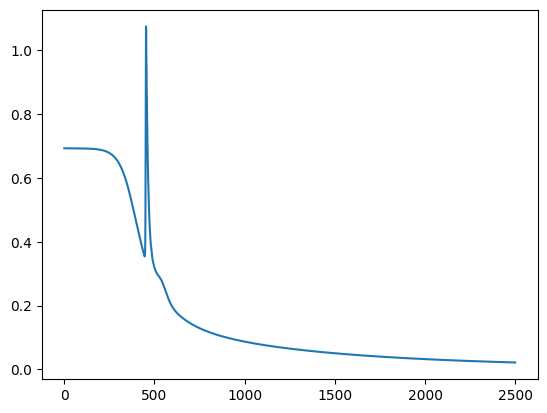

In [35]:
plt.plot(range(len(cost_list)),cost_list)
plt.show()

### Making predictions

We don't just want to train a neural network, we also want to use it to make predictions. For this purpose, we create a `predict` function, that takes an input X, as well as the parameters of the trained model.

Don't worry about computing the prediction - we have already done so, when we implemented the forward propagation. Note that forward propagation takes as input both an `X` and a `y`, but we don't care about the cost (only about the `yHat = cache['A2']`, so we can give an empty `y`, as long as it has the correct shape.

In [36]:
def predict(X,parameters):
    _, cache = forward_propagation(X,np.zeros((X.shape[0],1)),parameters)
    yHat = cache['A2']    # Get yHat from the cache
    y_prediction = (yHat > 0.5)      # Make a prediction - when yHat > 0.5, assume 1, otherwise 0
    return y_prediction

Let's see how well our predictions perform, both on the training set and the test set:

In [39]:
y_prediction_test = predict(X_test_flat,parameters)
y_prediction_train = predict(X_train_flat,parameters)

print("train accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100))

train accuracy: 99.7134670487106 %
test accuracy: 95.16129032258064 %


Getting there! Certainly some overfitting happening, but 95% test accuracy is not bad at all.